In [1]:
%matplotlib inline

In [2]:
!hostname

mum-hpc2-gpu1


In [3]:
%cd ICRA_2023

/home/ssap0002/ICRA_2023


In [4]:
from VRNN_DAT import VRNN_DAT
from RNN import GRU, LSTM

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

2022-09-06 18:48:37.700286: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Data Loading

In [5]:
import os
import numpy as np
import pickle5 as pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

ORI_DATA_DIR = 'data/gripper/full'
HALF_DATA_DIR = 'data/gripper/half'
SYNTH_DATA_DIR = 'output/'

In [6]:
def to_timeseries(X, y, time_steps = 50):
    dataX = []
    dataY = []
    # Cut data by sequence length
    for i in range(0, len(X) - time_steps):
        _x = X[i:i+time_steps, :]
        _y = y[i:i+time_steps, :]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

def revert_timeseries(X, time_steps = 100):
  # if len(X[0]) == time_steps and time_steps != 1:
  #   return np.array(X[0])
  head = X[0]
  tail = np.array([f[time_steps-1] for f in X])
  return np.concatenate((head, tail))

def load_pickle(filepath):
    with open(filepath,'rb') as f:
      x = pickle.load(f)
      return x
    
def _preprocess(data):
  # Features
  flex = data['Flex'][0]
  pressure = data['Pressure'][0]

  # Labels
  f1, f2 = data['Force']
  x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = data['PosX']
  y1, y2, y3, y4, y5, y6, y7, y8, y9, y10 = data['PosY']
      
  x = list(zip(flex, pressure, f1, f2, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))
  return np.array(x)

def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def load_data(s, _from='Train', scaler=None):
  raw_data = load_pickle("data/new_soro_all.pkl")
  train = raw_data.xs(_from, axis=0, level=1, drop_level=True)

  raw_data = _preprocess(train[s])

  # Normalize 
  if scaler is None:
      label_scaler = MinMaxScaler(clip=True)
      feature_scaler = MinMaxScaler(clip=True)
    
      features, labels = feature_scaler.fit_transform(raw_data[:, :2]), label_scaler.fit_transform(raw_data[:, 2:])
      print(f"creating scaler from {s}")
      
  else:
    print("reusing scaler")
    label_scaler, feature_scaler = scaler
    features, labels = feature_scaler.transform(raw_data[:, :2]), label_scaler.transform(raw_data[:, 2:])
    

  # Timeseries
  X_train, y_train = to_timeseries(features, labels, params['timesteps'])

  return  X_train, y_train, (label_scaler, feature_scaler)

In [7]:
def load_dataset(datatype, datasets, batch_size, no_state_data=[], scaler=None):
    X_train, y_train, domain_labels = [], [], []
    
    if datatype == 'test':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Test', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        for i, (x,y) in enumerate(zip(X_train, y_train)):
            if i == 0:
                dataset = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                dataset = dataset.batch(batch_size)
            
            else: 
                _d = tf.data.Dataset.from_tensor_slices((x, y, domain_labels[i]))
                _d = _d.batch(batch_size)
                dataset = dataset.concatenate(_d)
        return dataset, scaler
    
    elif datatype == 'train':
        for scenario in datasets:
            _x, _y, scaler = load_data(scenario, _from='Train', scaler=scaler)
            X_train.append(np.array(_x).astype('float32')), y_train.append(np.array(_y).astype('float32'))
            if scenario in no_state_data:
                domain_labels.append([0 for _ in range(len(_x))])
            else:
                domain_labels.append([1 for _ in range(len(_x))])

        Xdata = np.concatenate(X_train)
        ydata = np.concatenate(y_train)
        Statedata = np.concatenate(domain_labels).astype(np.float32)

        # Shuffle
        p = np.random.permutation(len(Xdata))
        Xdata = Xdata[p]
        ydata = ydata[p]
        Statedata = Statedata[p]

        dataset =  tf.data.Dataset.from_tensor_slices((Xdata ,ydata, Statedata))
        return dataset.batch(batch_size), scaler

In [8]:
def get_dataset(model_type, train_scenario, batch_size):
    
    if train_scenario == "tip_contact":        
        all_datasets = ['osc_tip_30', 'rand_tip_30', 'osc_rand_30', 'rand_rand_60']
    elif train_scenario == "random_contact":
        all_datasets = ['osc_rand_30', 'rand_rand_60','osc_tip_30', 'rand_tip_30']
        
    if train_scenario == "tip_contact":
        _train_d = ['osc_tip_30', 'rand_tip_30']
    elif train_scenario == "random_contact":
        _train_d = ['osc_rand_30', 'rand_rand_60']
    
    _test_d = [d for d in all_datasets if d not in _train_d]
        
    if model_type == "GRU" or model_type == "LSTM":           
        train_dataset, scaler = load_dataset('train', _train_d, batch_size)
    
    elif model_type == "VRNN_DAT":
        train_dataset, scaler = load_dataset('train', all_datasets, batch_size, no_state_data=_test_d)
        
    test_dataset, _ = load_dataset('test', _test_d, batch_size, scaler=scaler)
    
    return train_dataset, test_dataset, scaler

def get_model(model_type, params=None):
    if model_type == "GRU":
        return GRU(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "LSTM":
        return LSTM(params['x_dim'], params['timesteps'], params['z_dim'], params['h_dim'])
    elif model_type == "VRNN":
        pass
    elif model_type == "VRNN_DAT":
        return VRNN_DAT(params['x_dim'], params['h_dim'], params['z_dim'], phi_x_dim=params['phi_x_dim'], d_dim=params['d_dim'], vrnn_lr=params['lr'], adv_lr=params['adv_lr'], clip=params['clip'], rnn=params['rnn'])

def evaluate_model(model, test_dataset):
    pred, y_test = [], []
    for step, (x_batch_test, y_batch_test, _) in enumerate(test_dataset):
        _pred = model.predict(x_batch_test)
        pred.append(_pred)
        y_test.append(y_batch_test)
        
    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)
    
    force_x_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    force_z_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    marker_rmse_metric = tf.keras.metrics.RootMeanSquaredError()
    
    force_x_rmse_metric.update_state(y_test[:, :, 0], pred[:, :, 0]).numpy()
    force_z_rmse_metric.update_state(y_test[:, :, 1], pred[:, :, 1]).numpy()
    
    force_rmse = (force_x_rmse_metric.result().numpy(), force_z_rmse_metric.result().numpy())

    marker_rmse_metric.update_state(y_test[:, :, 2:], pred[:, :, 2:]).numpy()
    marker_rmse = marker_rmse_metric.result().numpy()
    
    return force_rmse, marker_rmse

## Hyperparameters

In [9]:
x_dim = 2 # flex + pressure
h_dim = 128
z_dim = 22 # 2 force + 10*2D coordinates
phi_x_dim = 32
d_dim = 128
n_epochs = 50
clip = 5
lr = 1e-3
adv_lr = 1e-3
batch_size = 128 # 32
seed = 261199
timesteps=100
rnn="LSTM"
# tf.random.set_seed(seed)

In [10]:
from sorcery import dict_of

params = dict_of(x_dim, h_dim, z_dim, phi_x_dim, timesteps, d_dim, n_epochs, clip, lr, adv_lr, batch_size, rnn)

## Train Models

In [11]:
model_types = ["VRNN_DAT"]
# model_types = ["LSTM"]

scenarios = ['random_contact', 'tip_contact']
df = pd.DataFrame(columns=["Model", "Train Scenario", "Force_X_RMSE", "Force_Z_RMSE", "Marker_RMSE", "Run"])
                  
for model_type in model_types:
    for run in range(1, 6): 
        for train_scenario in scenarios:     
            print(f"================={model_type}_{params['rnn']}:{train_scenario}:{run}==================")
            # Prepare dataset and model
            train_dataset, test_dataset, scalers = get_dataset(model_type, train_scenario, params['batch_size'])
            model = get_model(model_type, params)

            # Train
            if model_type == "GRU" or model_type == "LSTM":
                model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
            else:
                model.compile()
            model.fit(train_dataset, epochs=params['n_epochs'], batch_size=params['batch_size'])

            # Save weights
            model.save_weights(f"weights/one_scaler/{model_type}_{params['rnn']}/{train_scenario}/run_{run}/")

            # Evaluate
            (force_x_rmse, force_z_rmse), marker_rmse = evaluate_model(model, test_dataset)

            # Write to df
            df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)
            
            print(f"================={model_type}_{params['rnn']}:{train_scenario}:{run}:{force_x_rmse}:{force_z_rmse}:{marker_rmse}==================")

=================VRNN_DAT_LSTM:random_contact:1==================
creating scaler from osc_rand_30
reusing scaler
reusing scaler
reusing scaler


2022-09-06 18:48:42.204943: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 18:48:42.627926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79132 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0


reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-06 18:51:23.433692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_4/gru/PartitionedCall:6 incompatible with expected variant.
2022-09-06 18:51:24.687730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 18:51:25.347238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 18:51:25.806852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 18:51:27.739171: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passe

583/583 [==============================] - 398s 349ms/step - loss: -147340.2812 - rmse: 0.2219
Epoch 2/50
583/583 [==============================] - 198s 340ms/step - loss: -248726.1250 - rmse: 0.1209
Epoch 3/50
583/583 [==============================] - 216s 371ms/step - loss: -281045.2188 - rmse: 0.1116
Epoch 4/50
583/583 [==============================] - 200s 343ms/step - loss: -304308.0312 - rmse: 0.1051
Epoch 5/50
583/583 [==============================] - 201s 344ms/step - loss: -323819.4062 - rmse: 0.0997
Epoch 6/50
583/583 [==============================] - 203s 349ms/step - loss: -340178.6875 - rmse: 0.0958
Epoch 7/50
583/583 [==============================] - 202s 347ms/step - loss: -353290.5625 - rmse: 0.0927
Epoch 8/50
583/583 [==============================] - 202s 346ms/step - loss: -364474.0625 - rmse: 0.0902
Epoch 9/50
583/583 [==============================] - 201s 344ms/step - loss: -373842.9062 - rmse: 0.0883
Epoch 10/50
583/583 [==============================] - 20

2022-09-06 21:43:40.798270: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:random_contact:1:0.039483241736888885:0.02791748195886612:0.07413114607334137==================
=================VRNN_DAT_LSTM:tip_contact:1==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-06 21:46:47.536519: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_9/gru_1/PartitionedCall:6 incompatible with expected variant.
2022-09-06 21:46:48.785675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 21:46:49.435638: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 21:46:49.919737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-06 21:46:51.841454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pas

583/583 [==============================] - 410s 367ms/step - loss: -60271.8555 - rmse: 0.2857
Epoch 2/50
583/583 [==============================] - 213s 365ms/step - loss: -115636.2812 - rmse: 0.1886
Epoch 3/50
583/583 [==============================] - 212s 363ms/step - loss: -134783.0156 - rmse: 0.1740
Epoch 4/50
583/583 [==============================] - 216s 371ms/step - loss: -149437.2188 - rmse: 0.1652
Epoch 5/50
583/583 [==============================] - 216s 370ms/step - loss: -159907.4375 - rmse: 0.1589
Epoch 6/50
583/583 [==============================] - 214s 367ms/step - loss: -168439.5781 - rmse: 0.1538
Epoch 7/50
583/583 [==============================] - 212s 363ms/step - loss: -176205.6875 - rmse: 0.1492
Epoch 8/50
583/583 [==============================] - 214s 367ms/step - loss: -182490.8750 - rmse: 0.1452
Epoch 9/50
583/583 [==============================] - 210s 360ms/step - loss: -188308.2344 - rmse: 0.1418
Epoch 10/50
583/583 [==============================] - 211

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:tip_contact:1:0.07127953320741653:0.06786561012268066:0.0959690511226654==================
=================VRNN_DAT_LSTM:random_contact:2==================
creating scaler from osc_rand_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 00:47:46.511998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_14/gru_2/PartitionedCall:6 incompatible with expected variant.
2022-09-07 00:47:47.708800: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 00:47:48.344538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 00:47:48.793160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 00:47:50.677431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 406s 364ms/step - loss: -146937.7812 - rmse: 0.2225
Epoch 2/50
583/583 [==============================] - 210s 360ms/step - loss: -248956.4062 - rmse: 0.1163
Epoch 3/50
583/583 [==============================] - 215s 368ms/step - loss: -283573.0938 - rmse: 0.1048
Epoch 4/50
583/583 [==============================] - 213s 365ms/step - loss: -305237.2188 - rmse: 0.0980
Epoch 5/50
583/583 [==============================] - 215s 369ms/step - loss: -323162.0938 - rmse: 0.0932
Epoch 6/50
583/583 [==============================] - 214s 367ms/step - loss: -338311.8125 - rmse: 0.0896
Epoch 7/50
583/583 [==============================] - 212s 364ms/step - loss: -349940.7188 - rmse: 0.0870
Epoch 8/50
583/583 [==============================] - 210s 361ms/step - loss: -359612.7812 - rmse: 0.0848
Epoch 9/50
583/583 [==============================] - 215s 370ms/step - loss: -369224.6562 - rmse: 0.0829
Epoch 10/50
583/583 [==============================] - 21

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:random_contact:2:0.06552528589963913:0.02841412089765072:0.06267186999320984==================
=================VRNN_DAT_LSTM:tip_contact:2==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 03:47:17.448893: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_19/gru_3/PartitionedCall:6 incompatible with expected variant.
2022-09-07 03:47:18.666542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 03:47:19.323888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 03:47:19.756849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 03:47:21.684829: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 407s 365ms/step - loss: -62429.2148 - rmse: 0.2923
Epoch 2/50
583/583 [==============================] - 213s 366ms/step - loss: -116272.8516 - rmse: 0.1891
Epoch 3/50
583/583 [==============================] - 211s 362ms/step - loss: -135372.6250 - rmse: 0.1725
Epoch 4/50
583/583 [==============================] - 210s 361ms/step - loss: -149886.7969 - rmse: 0.1630
Epoch 5/50
583/583 [==============================] - 227s 389ms/step - loss: -160693.3438 - rmse: 0.1571
Epoch 6/50
583/583 [==============================] - 211s 362ms/step - loss: -169063.7188 - rmse: 0.1522
Epoch 7/50
583/583 [==============================] - 212s 363ms/step - loss: -175509.5000 - rmse: 0.1483
Epoch 8/50
583/583 [==============================] - 225s 385ms/step - loss: -181585.2344 - rmse: 0.1452
Epoch 9/50
583/583 [==============================] - 211s 362ms/step - loss: -187200.3906 - rmse: 0.1423
Epoch 10/50
583/583 [==============================] - 211

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:tip_contact:2:0.07125445455312729:0.07186634838581085:0.10040871053934097==================
=================VRNN_DAT_LSTM:random_contact:3==================
creating scaler from osc_rand_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 06:58:27.631465: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_24/gru_4/PartitionedCall:6 incompatible with expected variant.
2022-09-07 06:58:29.843231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 06:58:31.023377: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 06:58:31.823288: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 06:58:35.084587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 551s 535ms/step - loss: -145643.7812 - rmse: 0.2226
Epoch 2/50
583/583 [==============================] - 293s 503ms/step - loss: -247308.0781 - rmse: 0.1163
Epoch 3/50
583/583 [==============================] - 307s 526ms/step - loss: -281254.1875 - rmse: 0.1065
Epoch 4/50
583/583 [==============================] - 300s 514ms/step - loss: -305143.3750 - rmse: 0.0999
Epoch 5/50
583/583 [==============================] - 298s 511ms/step - loss: -324140.5938 - rmse: 0.0949
Epoch 6/50
583/583 [==============================] - 287s 493ms/step - loss: -338280.6250 - rmse: 0.0914
Epoch 7/50
583/583 [==============================] - 241s 413ms/step - loss: -350295.8438 - rmse: 0.0889
Epoch 8/50
583/583 [==============================] - 219s 376ms/step - loss: -361146.1250 - rmse: 0.0868
Epoch 9/50
583/583 [==============================] - 221s 379ms/step - loss: -370059.9688 - rmse: 0.0848
Epoch 10/50
583/583 [==============================] - 21

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:random_contact:3:0.03929799795150757:0.030082223936915398:0.06980538368225098==================
=================VRNN_DAT_LSTM:tip_contact:3==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 10:07:19.704901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_29/gru_5/PartitionedCall:6 incompatible with expected variant.
2022-09-07 10:07:20.907402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 10:07:21.561212: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 10:07:21.997125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 10:07:23.847160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 406s 360ms/step - loss: -59299.2109 - rmse: 0.2880
Epoch 2/50
583/583 [==============================] - 209s 359ms/step - loss: -114886.3906 - rmse: 0.1879
Epoch 3/50
583/583 [==============================] - 209s 359ms/step - loss: -133842.0781 - rmse: 0.1739
Epoch 4/50
583/583 [==============================] - 209s 359ms/step - loss: -148141.7969 - rmse: 0.1653
Epoch 5/50
583/583 [==============================] - 210s 359ms/step - loss: -158237.4844 - rmse: 0.1589
Epoch 6/50
583/583 [==============================] - 207s 355ms/step - loss: -167577.4688 - rmse: 0.1536
Epoch 7/50
583/583 [==============================] - 209s 359ms/step - loss: -175273.0312 - rmse: 0.1492
Epoch 8/50
583/583 [==============================] - 208s 356ms/step - loss: -181519.8125 - rmse: 0.1459
Epoch 9/50
583/583 [==============================] - 210s 360ms/step - loss: -187044.2188 - rmse: 0.1429
Epoch 10/50
583/583 [==============================] - 210

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:tip_contact:3:0.07355823367834091:0.06540472060441971:0.09877098351716995==================
=================VRNN_DAT_LSTM:random_contact:4==================
creating scaler from osc_rand_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 13:05:29.291481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_34/gru_6/PartitionedCall:6 incompatible with expected variant.
2022-09-07 13:05:30.504052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 13:05:31.155065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 13:05:31.586238: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 13:05:33.467191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 406s 360ms/step - loss: -144801.6406 - rmse: 0.2232
Epoch 2/50
583/583 [==============================] - 210s 360ms/step - loss: -249070.1406 - rmse: 0.1166
Epoch 3/50
583/583 [==============================] - 211s 362ms/step - loss: -284606.0000 - rmse: 0.1042
Epoch 4/50
583/583 [==============================] - 210s 359ms/step - loss: -307967.9688 - rmse: 0.0975
Epoch 5/50
583/583 [==============================] - 213s 365ms/step - loss: -325734.6875 - rmse: 0.0931
Epoch 6/50
583/583 [==============================] - 209s 358ms/step - loss: -339711.5000 - rmse: 0.0903
Epoch 7/50
583/583 [==============================] - 211s 361ms/step - loss: -351760.4688 - rmse: 0.0877
Epoch 8/50
583/583 [==============================] - 212s 364ms/step - loss: -361778.0625 - rmse: 0.0856
Epoch 9/50
583/583 [==============================] - 208s 357ms/step - loss: -371993.2188 - rmse: 0.0833
Epoch 10/50
583/583 [==============================] - 21

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:random_contact:4:0.040269430726766586:0.054011814296245575:0.06682253628969193==================
=================VRNN_DAT_LSTM:tip_contact:4==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 16:15:43.776333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_39/gru_7/PartitionedCall:6 incompatible with expected variant.
2022-09-07 16:15:45.014142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 16:15:45.693432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 16:15:46.138905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 16:15:48.015035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 409s 361ms/step - loss: -57223.1406 - rmse: 0.2949
Epoch 2/50
583/583 [==============================] - 211s 362ms/step - loss: -115099.3516 - rmse: 0.1907
Epoch 3/50
583/583 [==============================] - 210s 361ms/step - loss: -134044.9375 - rmse: 0.1772
Epoch 4/50
583/583 [==============================] - 206s 354ms/step - loss: -148407.1875 - rmse: 0.1675
Epoch 5/50
583/583 [==============================] - 209s 359ms/step - loss: -159498.8750 - rmse: 0.1610
Epoch 6/50
583/583 [==============================] - 210s 359ms/step - loss: -168145.1406 - rmse: 0.1563
Epoch 7/50
583/583 [==============================] - 209s 358ms/step - loss: -175652.9844 - rmse: 0.1520
Epoch 8/50
583/583 [==============================] - 210s 360ms/step - loss: -181633.9062 - rmse: 0.1485
Epoch 9/50
583/583 [==============================] - 225s 385ms/step - loss: -186956.2812 - rmse: 0.1452
Epoch 10/50
583/583 [==============================] - 219

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:tip_contact:4:0.07500582933425903:0.06766317784786224:0.09921742230653763==================
=================VRNN_DAT_LSTM:random_contact:5==================
creating scaler from osc_rand_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 19:30:57.556444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_44/gru_8/PartitionedCall:6 incompatible with expected variant.
2022-09-07 19:30:59.480668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 19:31:00.506108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 19:31:01.247186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 19:31:04.147734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 496s 388ms/step - loss: -140289.4219 - rmse: 0.2194
Epoch 2/50
583/583 [==============================] - 208s 357ms/step - loss: -238763.0312 - rmse: 0.1175
Epoch 3/50
583/583 [==============================] - 208s 357ms/step - loss: -274577.4062 - rmse: 0.1072
Epoch 4/50
583/583 [==============================] - 209s 358ms/step - loss: -298609.3125 - rmse: 0.1002
Epoch 5/50
583/583 [==============================] - 207s 355ms/step - loss: -315692.0938 - rmse: 0.0957
Epoch 6/50
583/583 [==============================] - 210s 360ms/step - loss: -330843.1875 - rmse: 0.0922
Epoch 7/50
583/583 [==============================] - 208s 356ms/step - loss: -342513.6250 - rmse: 0.0894
Epoch 8/50
583/583 [==============================] - 211s 362ms/step - loss: -355218.8438 - rmse: 0.0866
Epoch 9/50
583/583 [==============================] - 209s 359ms/step - loss: -364633.6562 - rmse: 0.0841
Epoch 10/50
583/583 [==============================] - 20

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


=================VRNN_DAT_LSTM:random_contact:5:0.04064047709107399:0.029502632096409798:0.07683702558279037==================
=================VRNN_DAT_LSTM:tip_contact:5==================
creating scaler from osc_tip_30
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
Using LSTM Backend
Epoch 1/50


2022-09-07 22:43:15.299775: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was passed float from StatefulPartitionedCall/sequential_49/gru_9/PartitionedCall:6 incompatible with expected variant.
2022-09-07 22:43:16.621040: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] shape_optimizer failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 22:43:17.341568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 22:43:17.803951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] remapper failed: OUT_OF_RANGE: src_output = 31, but num_outputs is only 25
2022-09-07 22:43:19.734223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node StatefulPartitionedCall/zeros_like_2708 was pa

583/583 [==============================] - 421s 377ms/step - loss: -59241.7031 - rmse: 0.2888
Epoch 2/50
583/583 [==============================] - 218s 375ms/step - loss: -115402.6875 - rmse: 0.1879
Epoch 3/50
583/583 [==============================] - 217s 372ms/step - loss: -133915.0781 - rmse: 0.1744
Epoch 4/50
583/583 [==============================] - 218s 374ms/step - loss: -147913.9219 - rmse: 0.1658
Epoch 5/50
583/583 [==============================] - 218s 374ms/step - loss: -158533.4688 - rmse: 0.1593
Epoch 6/50
583/583 [==============================] - 218s 375ms/step - loss: -166795.1094 - rmse: 0.1537
Epoch 7/50
583/583 [==============================] - 217s 372ms/step - loss: -174720.3750 - rmse: 0.1493
Epoch 8/50
583/583 [==============================] - 219s 375ms/step - loss: -181270.5625 - rmse: 0.1454
Epoch 9/50
583/583 [==============================] - 218s 373ms/step - loss: -187595.8906 - rmse: 0.1412
Epoch 10/50
583/583 [==============================] - 267

/tmp/ipykernel_2867336/710557349.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Model": model_type, "Train Scenario": train_scenario, 'Force_X_RMSE': force_x_rmse, 'Force_Z_RMSE': force_z_rmse, 'Marker_RMSE': marker_rmse, "Run": run}, ignore_index=True)


In [12]:
df.to_csv('vrnn_dat_lstm_onescaler_results.csv', index=False)

In [25]:
df.head()

,Model,Train Scenario,Force_X_RMSE,Force_Z_RMSE,Marker_RMSE,Run
0,VRNN_DAT,tip_contact,0.070997,0.066864,0.096813,1


In [26]:
VRNN_DAT = model

In [27]:
train_dataset, test_dataset, scalers = get_dataset("VRNN_DAT", scenarios[0], params['batch_size'])

creating scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler
reusing scaler


In [28]:
plt.style.use('seaborn')
def plot(axes, model, color='blue', l="label", vrnn=False, run=0):
    pred, y_test = [] , []
    for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
        if not vrnn:
            _pred = model.predict(x_batch_test, verbose=0)
        else:
            _pred = model.predict(x_batch_test)
            
        pred.append(_pred)
        y_test.append(y_batch_test)

    pred = np.concatenate(pred)
    y_test = np.concatenate(y_test)

    pred = revert_timeseries(pred, timesteps)
    
    # predicted_arr = revert_scaling(scalers, pred)
    
    predicted_arr = scalers[0].inverse_transform(pred)
    
    
        
    a1,a2,a3,a4 = axes
    
    x = 0.1*np.arange(np.shape(predicted_arr[:])[0])

    a1.plot(x, predicted_arr[:, 0], label=l, linewidth=1, color=color)

    a2.plot(x, predicted_arr[:, 1], label=l, linewidth=1, color=color)
           
    a3.plot(x, predicted_arr[:, 11], label=l, linewidth=1, color=color)

    a4.plot(x, predicted_arr[:, -1], label=l, linewidth=1, color=color)

    return predicted_arr

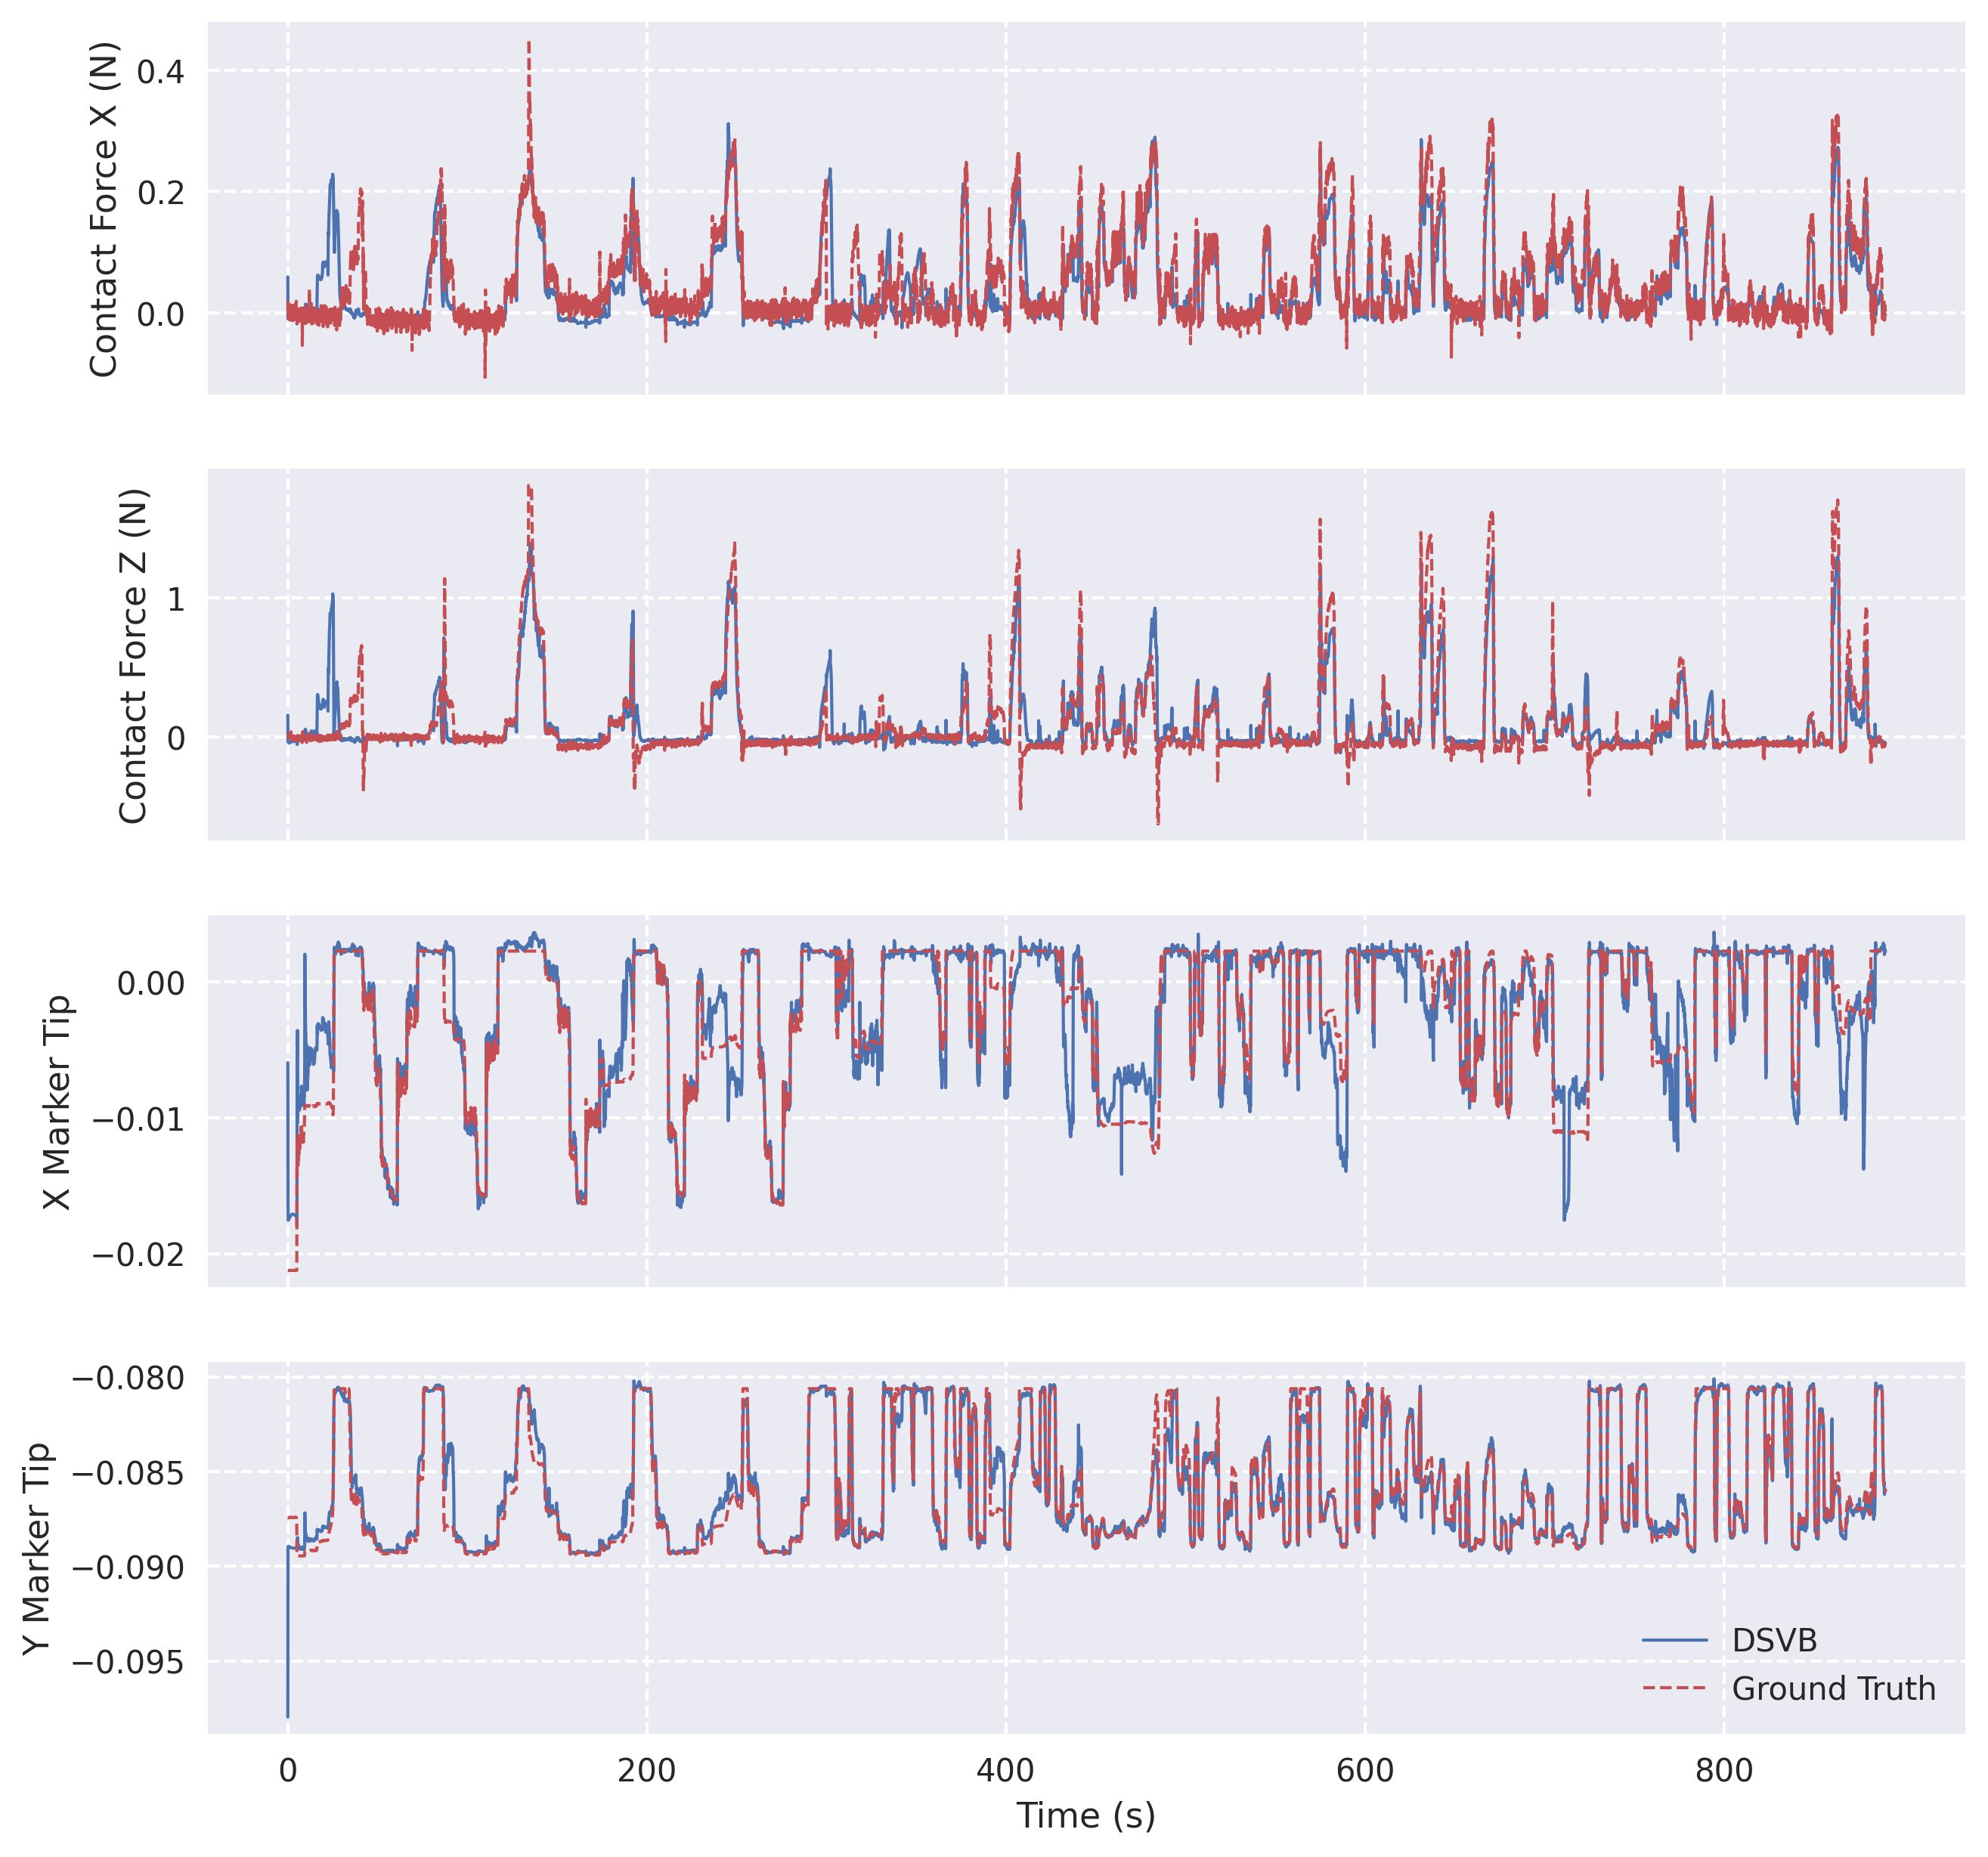

In [29]:
import seaborn as sns

y_test = []
for step, (x_batch_test, y_batch_test, state_available) in enumerate(test_dataset):
    y_test.append(y_batch_test)

y_test = np.concatenate(y_test)

plotted_y_test = scalers[0].inverse_transform(revert_timeseries(y_test, timesteps))
# plotted_y_test = revert_timeseries(y_test, timesteps)


force_labels_x = plotted_y_test[:, 0]
force_labels_z = plotted_y_test[:, 1]  
x_tip = plotted_y_test[:, 11]
y_tip = plotted_y_test[:, -1]


labels_arr = [force_labels_x, force_labels_z, x_tip, y_tip]
x_title = ["Force X (N)", "Force Z (N)", "X Tip", "Y Tip"]

f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True, figsize=(10,10), dpi=300)
# f, (a1,a2,a3,a4) = plt.subplots(4,1,sharex=True)  

a1.set_ylabel('Contact Force X (N)')
a2.set_ylabel('Contact Force Z (N)')
a3.set_ylabel('X Marker Tip')
a4.set_ylabel('Y Marker Tip')

x = 0.1*np.arange(np.shape(plotted_y_test)[0])

axes = (a1, a2, a3, a4)
labels = ["DSVB"]

ESTIMATIONS = []
c = [sns.color_palette()[0], sns.color_palette()[4], sns.color_palette()[1]]
for i, model in enumerate([VRNN_DAT]):
    ESTIMATIONS.append(plot(axes, model, l=labels[i], vrnn=True if labels[i] == "DSVB" else False, color=c[i]))
    
a1.plot(x,labels_arr[0], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a1.grid(linestyle = '--',)

a2.plot(x, labels_arr[1], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)
a2.grid(linestyle = '--',)

a3.grid(linestyle = '--',)
a3.plot(x, labels_arr[2],color=sns.color_palette()[2],  linestyle="--", label='Ground Truth', linewidth=1)

a4.grid(linestyle = '--',)
a4.plot(x, labels_arr[3], color=sns.color_palette()[2], linestyle="--", label='Ground Truth', linewidth=1)

a4.set_xlabel("Time (s)")
    
# a1.legend()
# a2.legend()
# a3.legend()
a4.legend()
# plt.savefig("estimations.png")
plt.show()
